In [1]:
#from IPython.external import mathjax; mathjax.install_mathjax()
import matplotlib
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import healpy as hp
import healpy.projector as pro
import astropy.units as u
import astropy.constants as c
import astropy.io.fits as fits
from   scipy.stats import gaussian_kde
from   scipy.stats import sigmaclip
import scipy
import pandas as pd
import pickle
from   pylab import arange, show, cm
import seaborn as sb
from scipy.stats import spearmanr



%matplotlib inline


colors = ['tab:blue', 
          'tab:orange', 
          'tab:green', 
          'tab:red', 
          'tab:purple', 
          'tab:brown', 
          'tab:pink', 
          'tab:gray', 
          'tab:olive', 
          'tab:cyan']


fisColor  = colors[0]
IColor = colors[1]
ircColor  = colors[2]
hfiColor  = colors[3]
WColor = colors[4]


fontsize=20




In [2]:
with open('../Data/maps_nest.pickle') as f:  # Python 3: open(..., 'rb')
    coords, planck_bb, planck_mw,  phot, phot_modesub, phot_mpsub = pickle.load(f)
planck_bb.columns



Index([u'$T$', u'$B$', u'$I_{dust}(545)$', u'$R_{PR1}$', u'$\tau_{353,PR1}$',
       u'$U$'],
      dtype='object')

%%latex
\section{Make band pass plot}

%%latex
\subsection{Load in the Filters}
Filters taken from \cite{doi15}

In [3]:
filters_dir = "/work1/users/aaronb/Databrary/Filters/"


I12  = pd.read_csv(filters_dir+"filter_iras12", 
                      names= ['Wavelength','I12'],
                      header=0)
W12  = pd.read_csv(filters_dir+"filter_wise12", 
                      names= ['Wavelength','W12'],
                      header=0)
A9  = pd.read_csv(filters_dir+"filter_akari9", 
                      names= ['Wavelength','A9'],
                      header=0)
A18 = pd.read_csv(filters_dir+"filter_akari18", 
                      names= ['Wavelength','A18'],
                      header=0)
I25  = pd.read_csv(filters_dir+"filter_iras25", 
                      names= ['Wavelength','I25'],
                      header=0)
I60  = pd.read_csv(filters_dir+"filter_iras60", 
                      names= ['Wavelength','I60'],
                      header=0)

A65  = pd.read_csv(filters_dir+"filter_akari65", 
                      names= ['Wavelength','A65'],
                      header=0)

A90  = pd.read_csv(filters_dir+"filter_akari90", 
                      names= ['Wavelength','A90'],
                      header=0)

I100  = pd.read_csv(filters_dir+"filter_iras100", 
                      names= ['Wavelength','I100'],
                      header=0)

A140  = pd.read_csv(filters_dir+"filter_akari140", 
                      names= ['Wavelength','A140'],
                      header=0)

A160  = pd.read_csv(filters_dir+"filter_akari160", 
                      names= ['Wavelength','A160'],
                      header=0)

planck857= pd.read_csv(filters_dir+"filter_planck857", 
                      names= ['Wavelength','PLANCK857'],
                      header=0)

planck545= pd.read_csv(filters_dir+"filter_planck545", 
                      names= ['Wavelength','PLANCK545'],
                      header=0)



%%latex
\subsection{MIR Data}

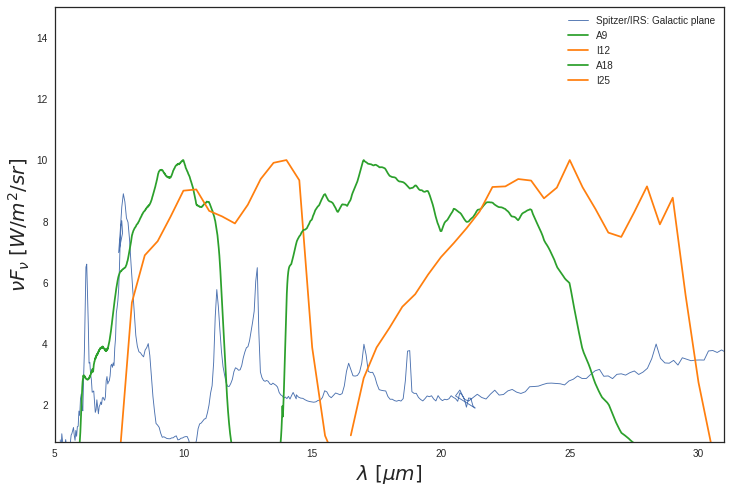

In [4]:
plt.figure(figsize = (12,8))
onakaMIR = pd.read_table('../Data/cirrus2 9_35_52  2005_02_26.txt', 
                      names= ['Wavelength','Spitzer/IRS'],
                      header=0)
onakaMIR['Spitzer/IRS']*u.Jy
onakaMIR['Spitzer/IRS'] *= c.c/onakaMIR['Wavelength']*u.um.to(u.m)
#print onakaMIR['MIR'][1]
#onakaMIR['Wavelength'] *= u.micron
#onakaMIR['MIR'].values.to(u.Joule)
with sb.axes_style("white"):
    plt.plot(onakaMIR['Wavelength'],
             onakaMIR['Spitzer/IRS'],
             label= 'Spitzer/IRS: Galactic plane', linewidth=0.9)
    plt.ylabel('$\\nu{}F_{\\nu}$ $[W/m^{2}/sr]$', fontsize=fontsize)
    plt.xlabel('$\lambda$ $[\mu{}m]$', fontsize=fontsize)
    plt.plot(A9.Wavelength,A9.A9*10,label="A9", color=ircColor)
    plt.plot(I12.Wavelength,I12.I12*10,label="I12", color=IColor)
    plt.plot(A18.Wavelength,A18.A18*10,label="A18", color=ircColor)
    plt.plot(I25.Wavelength,I25.I25*10,label="I25", color=IColor)
    plt.xlim(5,31)
    plt.ylim(0.8,15)
    plt.legend()
    #plt.vlines(6.2,7,10,linestyles = 'dashed')
    #plt.vlines(7.7,9,10,linestyles = 'dashed')
    #plt.vlines(11.2,6,10,linestyles = 'dashed')
    
    plt.savefig('../Plots/ch_datasources/Filter_coverage_example_MIR.pdf')
#scale_factor = 2.0 # Scales the obs data and models for visiblity

#onakaMIR.MIR*=scale_factor


/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in expm1
  *arrays, **kwargs)


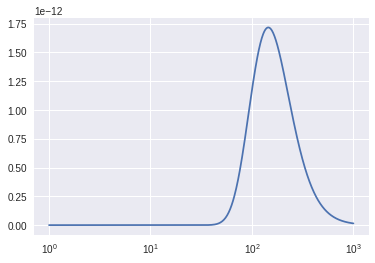

In [5]:
from astropy.modeling.blackbody import blackbody_lambda
bb_wave = np.linspace(1,1000,1000)*u.micron
bb = blackbody_lambda(bb_wave, 20*u.K)
plt.plot(bb_wave, bb.value*bb.value.max())
plt.xscale('log')

%%latex
\subsection{Modified black body: Emissivity 'correction'}

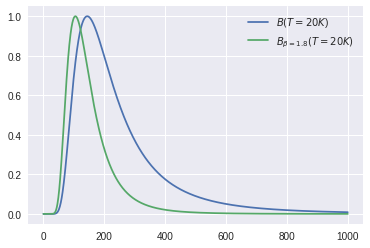

In [6]:
ref_wave = 550*u.micron # Arbitrary 'pivot' wavelength 
beta = 1.8 # Emissivity index
bb_corr = (ref_wave/bb_wave)**beta

mbb = bb *bb_corr


plt.plot(bb_wave, bb.value/bb.value.max(), label = '$B(T=20K$)')
plt.plot(bb_wave, mbb.value/mbb.value.max(), label = '$B_{\\beta{}=1.8}(T=20K)$')
#plt.xscale('log')
plt.legend()


mbb = pd.DataFrame(
    np.array([bb_wave,mbb]).T,
    columns=['Wavelength','MBB'])

#mbb.MBB/=mbb.MBB.max()

mbb.MBB /= mbb.Wavelength


#mbb.MBB*=scale_factor

### Import DustEM example SEDs

In [7]:
ex_SED_file = "../Data/SED_example_DustEM.txt"
#ex_SED = 
ex_SED = pd.DataFrame(
    np.genfromtxt(ex_SED_file),
    columns = ['Wavelength','PAH0','PAH1','acB0','acB1','aSil', 'Total'])
ex_SED.describe()


ex_SED_norm = ex_SED.copy()
ex_SED_norm[['PAH0','PAH1','acB0','acB1','aSil', 'Total']] /= ex_SED_norm['Total'].max()


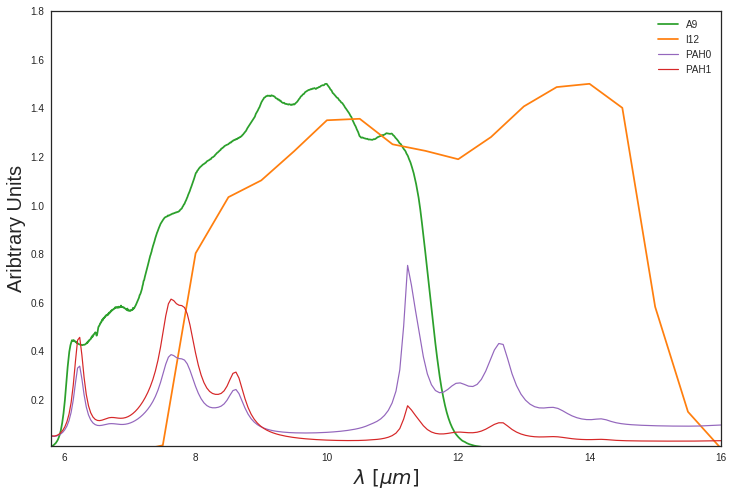

In [8]:
plt.figure(figsize = (12,8))

with sb.axes_style("white"):
    plt.ylabel('Aribtrary Units', fontsize=fontsize)
    plt.xlabel('$\lambda$ $[\mu{}m]$', fontsize=fontsize)
    plt.plot(A9.Wavelength,A9.A9*1.5,label="A9", color=ircColor)
    plt.plot(I12.Wavelength,I12.I12*1.5,label="I12", color=IColor)
    plt.plot(ex_SED_norm['Wavelength'],ex_SED_norm['PAH0'],linewidth=1.2, color =  colors[-6])
    plt.plot(ex_SED_norm['Wavelength'],ex_SED_norm['PAH1'],linewidth=1.2, color =  colors[-7])

    plt.legend()
    plt.ylim((0.01,1.8))
    plt.xlim((5.8,16))
    plt.savefig('../Plots/ch_datasources/Filter_coverage_example_PAH.pdf')
#scale_factor = 2.0 # Scales the obs data and models for visiblity

#onakaMIR.MIR*=scale_factor


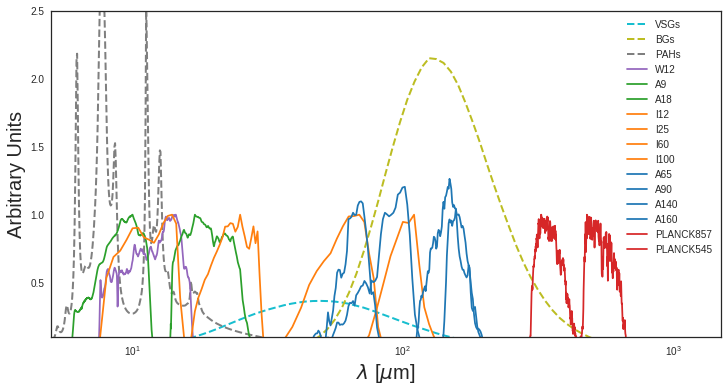

In [9]:
# Set ranges:
xmax = 1.5e3
xmin = 5
ymin = 0.1
ymax = 2.5
logx = True

#colors = sb.color_palette("tab")


with sb.axes_style("white"):

    fig = plt.figure(figsize = (12,6))
    #gs1 = gridspec.GridSpec(2, 1)
    #gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 
    ax1 = fig.add_subplot(111)
    
#     ax1.plot(ex_SED_norm['Wavelength'],
#                      ex_SED_norm['Total']*2, 
#                      #linestyle = 'dashed',
#                      color = 'black',
#                      linewidth = 1,
#                      label = 'Dust SED')
    
    ax1.plot(ex_SED_norm['Wavelength'],
                     ex_SED_norm['acB0']*6, 
                     linestyle = 'dashed',
                     color = colors[-1],
                     linewidth = 2.0,
                     label = 'VSGs')
    
    ax1.plot(ex_SED_norm['Wavelength'],
                     (ex_SED_norm['acB1']+ex_SED_norm['aSil'])*2.75, 
                     linestyle = 'dashed',
                     color = colors[-2],
                     linewidth = 2.0,
                     label = 'BGs')
    
    ax1.plot(ex_SED_norm['Wavelength'],
                     (ex_SED_norm['PAH0']+ex_SED_norm['PAH1'])*2.75, 
                     linestyle = 'dashed',
                     color = colors[-3],
                     linewidth = 2.0,
                     label = 'PAHs')
    
    # Plot the filters
    #W12_norm['W12'] = (W12['W12'] - W12['W12'].mean()) / (W12['W12'].max() - W12['W12'].min())
    W12_norm = W12
    W12_norm['W12'] = (W12['W12']  / W12['W12'].max())

    W12_norm.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = WColor)
    
    A9.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = ircColor)
    A18.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = ircColor)
   
    I12.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = IColor)
    I25.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = IColor)
    I60.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = IColor)
    I100.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = IColor)
    
    A65.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = fisColor)
    A90.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = fisColor)
    A140.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = fisColor)
    A160.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = fisColor)
    
    planck857.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color=hfiColor)
    planck545.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax),
                   ylim=(ymin,ymax),
                   ax=ax1, color = hfiColor)
    
    
    # Plot the MIR spectrum
    
    #onakaMIR.plot(x='Wavelength',y='MIR',xlim=(xmin,xmax),ylim = (ymin, ymax), ax = ax1)
    
    # Plot FIR modified blackbody
    
#     mbb.plot(x='Wavelength',
#              xlim=(xmin,xmax),
#              ylim = (ymin, ymax), 
#              ax = ax1)
    
    plt.xlabel('$\lambda$ [$\mu$m]', fontsize=fontsize)
    plt.ylabel("Arbitrary Units", fontsize=fontsize)
    plt.legend()
    plt.savefig('../Plots/ch_datasources/Filter_coverage_example_full.pdf')
    

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


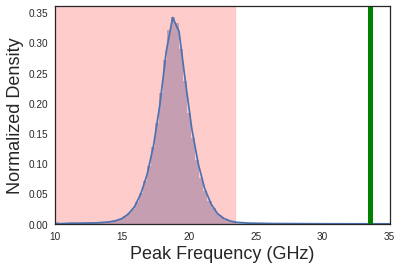

In [10]:
import matplotlib
with sb.axes_style("white"):
    fontsize = 18
    
    ame_freq_allsky = hp.read_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_var_FREQ_MEAN.fits')
    plt.figure()
    nuhist = sb.distplot(ame_freq_allsky[ame_freq_allsky!=hp.UNSEEN],
                rug=False, bins = 200 )

    nuhist.set_xlim(10,35)
    nuhist.set_xlabel("Peak Frequency (GHz)", fontsize=fontsize)
    nuhist.set_ylabel("Normalized Density", fontsize=fontsize)
    #nuhist.set_title("Per-pixel AME $\\nu_{peak}$ not well constrained", fontsize=fontsize)
    nuhist.axvline(x=33.5, ymin=0, ymax = 1, linewidth=5, color='g')

    nuhist.axvspan(8, 23.5, alpha=0.2, color='red')
    plt.savefig("../Plots/ch_intro/AME_commander_freqdist.pdf")


In [11]:
cmap = cm.rainbow
cmap.set_under('w')

In [12]:
PCCS_crossmatrix = planck_mw.join(planck_bb[['$I_{dust}(545)$','$T$','$B$']]).corr(method='spearman')

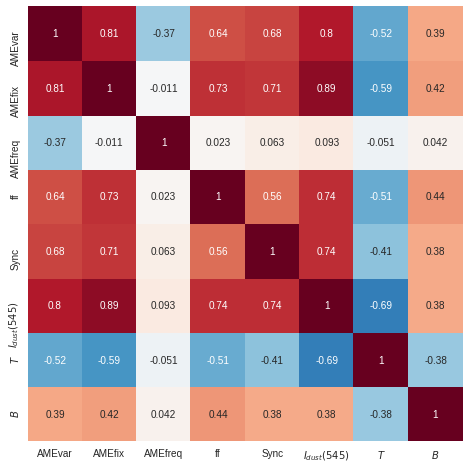

In [13]:
plt.figure(figsize=(8,8))
sb.heatmap(PCCS_crossmatrix,
          square=True,
          annot=True,
           cbar=False
          )
plt.savefig('../Plots/ch_datasources/PCCS_corrmatrix.pdf')

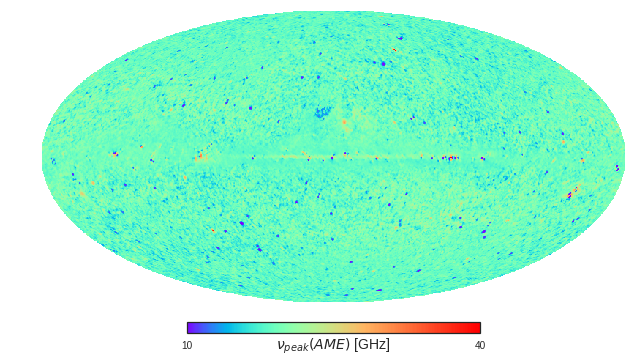

In [14]:
with sb.axes_style("white"):
    

    hp.mollview(planck_mw['AMEfreq'], 
                   norm='log', 
                    nest=True, 
                    min = 10,
                    max = 40, 
                    cmap=cmap,
                title='',
                    unit = '$\\nu_{peak}(AME)$ [GHz]')
    plt.savefig('../Plots/ch_datasources/PCAME_var_freq.pdf')

NameError: name 'ancillframe' is not defined

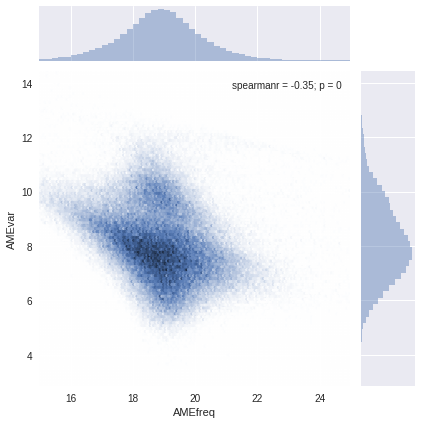

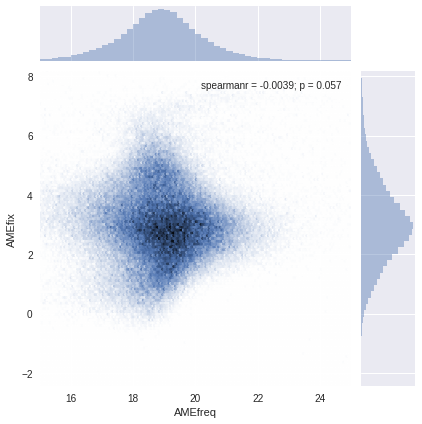

In [15]:
rand_seed = 42

sb.jointplot(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)],
             np.log(planck_mw['AMEvar'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)]), 
             kind= 'hex',
            stat_func = spearmanr)
plt.savefig('../Plots/ch_allsky/AMEfreq_vs_var.pdf')

sb.jointplot(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)],
             np.log(planck_mw['AMEfix'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)]), 
             kind= 'hex',
            stat_func = spearmanr)
plt.savefig('../Plots/ch_allsky/AMEfreq_vs_fix.pdf')


sb.jointplot(ancillframe['$H_{a}$'].divide(ancillframe['$N_{H}$']).sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)],
             np.log(planck_mw['AMEfix'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)]), 
             kind= 'hex',
            stat_func = spearmanr)

In [ ]:
def plotClippedHist(data,sigma, log=False):
    c, upp, low = sigmaclip(data,sigma ,sigma)
    
    label = data.name
    
    with sb.axes_style("white"):
        if log == True:
            sb.distplot(np.log10(c), bins =300, label=label)
        else:
            sb.distplot(c, bins=300, label=label)
        
    plt.legend()
    
plotClippedHist(planck_mw['AMEvar'], 15, log=True)
plotClippedHist(planck_mw['AMEfix'], 15, log=True)
#plotClippedHist(planck_mw['AMErad'], 15, log=True)
plt.xlabel('$log(I_{peak})$ [$\mu{}K_{RJ}]$')
plt.ylabel('Density')
plt.savefig('../Plots/ch_datasources/AME_comps_distplot.pdf')

In [ ]:
filters = pd.DataFrame.from_csv("/work1/users/aaronb/Codebrary/Python/filters_PAH.dat", header=0)

# Compare PAH Ionization fraction in different bands and stuff:

In [ ]:
filters.columns

In [ ]:
filters.columns = [u'I12/PAH0', u'I12/PAH1', u'I12/SAmC', u'I12/LAmC',
       u'I12/ASIL', u'I12/TOTAL', u'I25/PAH0', u'I25/PAH1',
       u'I25/SAmC', u'I25/LAmC', u'I25/ASIL', u'I25/TOTAL',
       u'W12/PAH0', u'W12/PAH1', u'W12/SAmC', u'W12/LAmC',
       u'W12/ASIL', u'W12/TOTAL', u'W22/PAH0', u'W22/PAH1',
       u'W22/SAmC', u'W22/LAmC', u'W22/ASIL', u'W22/TOTAL',
       u'A9/PAH0', u'A9/PAH1', u'A9/SAmC', u'A9/LAmC',
       u'A9/ASIL', u'A9/TOTAL', u'A18/PAH0', u'A18/PAH1',
       u'A18/SAmC', u'A18/LAmC', u'A18/ASIL', u'A18/TOTAL']

%%latex
\section{PAH Ionization Fraction Example}

In [ ]:
AmC = ['I12/SAmC', 'I12/LAmC',      
       'I25/SAmC', 'I25/LAmC', 
  'A9/SAmC','A18/SAmC']
SAmC = ['I12/SAmC',     
       'I25/SAmC', 
  'A9/SAmC','A18/SAmC']
ASIL = ['I12/ASIL',       'A9/ASIL']
PAH = ['A9/PAH0','A9/PAH1','I12/PAH0','I12/PAH1']
TOTALandPAH = ['A9/PAH0','A9/PAH1','I12/PAH0','I12/PAH1','A9/TOTAL','I12/TOTAL']

# [u'I12/PAH0', u'I12/PAH1', u'I12/SAmC', u'I12/LAmC',
#        u'I12/ASIL', u'I12/TOTAL', u'I25/PAH0', u'I25/PAH1',
#        u'I25/SAmC', u'I25/LAmC', u'I25/ASIL', u'I25/TOTAL',
#        u'W12/PAH0', u'W12/PAH1', u'W12/SAmC', u'W12/LAmC',
#        u'W12/ASIL', u'W12/TOTAL', u'W22/PAH0', u'W22/PAH1',
#        u'W22/SAmC', u'W22/LAmC', u'W22/ASIL', u'W22/TOTAL',
#        u'A9/PAH0', u'A9/PAH1', u'A9/SAmC', u'A9/LAmC',
#        u'A9/ASIL', u'A9/TOTAL', u'A18/PAH0', u'A18/PAH1',
#        u'A18/SAmC', u'A18/LAmC', u'A18/ASIL', u'A18/TOTAL']

In [ ]:
plt.figure(); filters[PAH].plot(logx=True)

In [ ]:
filters[PAH].ix[5].plot(kind='bar',
                        stacked=True); 
#plt.axhline(0, color='k')
plt.ylabel('In-band Fractional Contribution')

In [ ]:
with sb.axes_style("white"):
    filters[PAH].ix[5].plot(kind='bar',
                            stacked=True,
                            sort_columns = ['A9/PAH1','I12/PAH1','I12/PAH0','A9/PAH0'],
                            **{'linewidth':2.5, 
                               'linewidth':2.5, 
                               'facecolor':(1, 1, 1, 0),
                               'edgecolor':(".2",".2",".2",".2")}); 
    plt.axhline(0, color='k')
    plt.ylabel('In-band Fractional Contribution')
    plt.xticks(rotation='horizontal')
    plt.savefig('../Plots/ch_datasources/InBandFracContribution_PAH.pdf')

In [ ]:
plt.figure(); 
filters[TOTALandPAH].plot(logx=True)

In [ ]:
plt.figure(); 
filters[ASIL].plot(logx=True)

In [ ]:
g100 = pd.DataFrame.from_csv("../Data/band-ratio-G100.dat",header=1)
#g100
g1000 = pd.DataFrame.from_csv("../Data/band-ratio-G1000.dat",header=1, index_col=None)
#g1000
g10000 = pd.DataFrame.from_csv("../Data/band-ratio-G10000.dat",header=1, index_col=None)
#g10000

def plot_ifrac(df,filename,g0):

    f = plt.figure()
    df[df.columns[-5:-1]].plot(ax=f.gca(),linewidth=2.0)
    plt.ylabel("Band Ratio",fontsize=20)
    plt.xlabel("PAH Ionization Fraction",fontsize=20)
    plt.xlim(0,1)
    plt.title("$G_{0}$ = "+str(g0),fontsize=20)
    f.show()
    f.savefig("../Plots/ch_datasources/"+filename)
    #plt.close()


plot_ifrac(g100, "band-ratio-G100.pdf", 100)
plot_ifrac(g1000, "band-ratio-G1000.pdf",1000)
plot_ifrac(g10000, "band-ratio-G10000.pdf",10000)

def plot_big_ifrac(df1,df2,df3,filename):

    fig = plt.figure()

    plt.ylabel("Band Ratio")

    ax1 = plt.subplot(311)
    
g100 = pd.DataFrame.from_csv("../Data/band-ratio-G100.dat",header=1)
#g100
g1000 = pd.DataFrame.from_csv("../Data/band-ratio-G1000.dat",header=1, index_col=None)
#g1000
g10000 = pd.DataFrame.from_csv("../Data/band-ratio-G10000.dat",header=1, index_col=None)
#g10000

def plot_ifrac(df,filename,g0):

    f = plt.figure()
    df[df.columns[-5:-1]].plot(ax=f.gca(),linewidth=2.0)
    plt.ylabel("Band Ratio",fontsize=20)
    plt.xlabel("PAH Ionization Fraction",fontsize=20)
    plt.xlim(0,1)
    plt.title("$G_{0}$ = "+str(g0),fontsize=20)
    f.show()
    f.savefig("../Plots/ch_datasources/"+filename)
    #plt.close()


plot_ifrac(g100, "band-ratio-G100.pdf", 100)
plot_ifrac(g1000, "band-ratio-G1000.pdf",1000)
plot_ifrac(g10000, "band-ratio-G10000.pdf",10000)


In [ ]:

def plot_big_ifrac(df1,df2,filename):
    with sb.axes_style("white"):
        fig = plt.figure()

        plt.ylabel("Band Ratio")

        ax1 = plt.subplot(211)
        df1[df1.columns[-5:-3]].plot(ax=ax1,linewidth=2.0, )
        #plt.setp(ax1.get_xticklabels(), fontsize=6)

        ax2 = plt.subplot(212, sharex=ax1)
        plt.setp(ax2.get_xticklabels(), visible=True)
        df2[df2.columns[-5:-3]].plot(ax=ax2,legend=None, linewidth=2.0)
        plt.setp(ax1.get_xticklabels(), fontsize=6)

    
        plt.xlim(0,1)
        plt.xlabel("PAH Ionization Fraction",fontsize=20)
        plt.ylabel("Band ratio")


        #plt.show()
        plt.savefig("../Plots/ch_datasources/"+filename)

plot_big_ifrac(g100, g1000, "band-ratio-multiple.pdf")